In [ ]:
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pickle
import networkx as nx
from scipy.spatial import distance
import community as community_louvain
from tqdm import tqdm
import time
import scipy.stats as stats

In [ ]:
with open('/content/drive/MyDrive/Progetto DSN/Analysis_Data/area_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Ora puoi accedere ai dati caricati
VISp = loaded_data['VISp']
VISal = loaded_data['VISal']
SSp_bfd = loaded_data['SSp_bfd']

In [ ]:
# Funzione per creare un grafo da un DataFrame SWC
def create_graph_from_swc(df):
    G = nx.DiGraph()

    # Aggiungi nodi
    for _, row in df.iterrows():
        G.add_node(row['Node Index'], pos=(row['X Coordinate'], row['Y Coordinate'], row['Z Coordinate']), type=row['Type'], radius=row['Radius'])

    # Aggiungi archi
    for _, row in df.iterrows():
        if row['Parent Node Index'] != -1:  # Se non è la radice
            G.add_edge(row['Parent Node Index'], row['Node Index'])
    return G

In [ ]:
# Creazione dei grafi per ogni neurone
VISp_graphs = [create_graph_from_swc(df) for df in VISp]
VISal_graphs = [create_graph_from_swc(df) for df in VISal]
SSp_bfd_graphs = [create_graph_from_swc(df) for df in SSp_bfd]

In [ ]:
# Funzione per calcolare il grado di ciascun nodo in un grafo
def calculate_degree_distribution(G):
    degree_sequence = [d for n, d in G.degree()]
    return degree_sequence

# Funzione per calcolare la distribuzione dei gradi per un insieme di grafi
def degree_distribution(graphs):
    all_degrees = []
    for G in tqdm(graphs, desc="Calculating degree distribution"):
        degree_seq = calculate_degree_distribution(G)
        all_degrees.extend(degree_seq)
    return all_degrees

# Funzione per visualizzare la distribuzione del degree
def plot_degree_distribution(degrees, title):
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
VISp_degrees = degree_distribution(VISp_graphs)
VISal_degrees = degree_distribution(VISal_graphs)
SSp_bfd_degrees = degree_distribution(SSp_bfd_graphs)

Calculating degree distribution: 100%|██████████| 110/110 [00:00<00:00, 160.69it/s]


In [11]:
# Funzione per calcolare la percentuale dei nodi con grado 2
def percentage_degree_two(degree_list):
    total_nodes = len(degree_list)
    nodes_with_degree_two = degree_list.count(2)
    return (nodes_with_degree_two / total_nodes) * 100

# Calcolo delle percentuali per ciascuna area
VISp_percentage_degree_two = percentage_degree_two(VISp_degrees)
VISal_percentage_degree_two = percentage_degree_two(VISal_degrees)
SSp_bfd_percentage_degree_two = percentage_degree_two(SSp_bfd_degrees)

# Stampa delle percentuali
print(f'Percentuale di nodi con grado 2 in VISp: {VISp_percentage_degree_two:.2f}%')
print(f'Percentuale di nodi con grado 2 in VISal: {VISal_percentage_degree_two:.2f}%')
print(f'Percentuale di nodi con grado 2 in SSp_bfd: {SSp_bfd_percentage_degree_two:.2f}%')


Percentuale di nodi con grado 2 in VISp: 92.18%
Percentuale di nodi con grado 2 in VISal: 92.39%
Percentuale di nodi con grado 2 in SSp_bfd: 92.92%


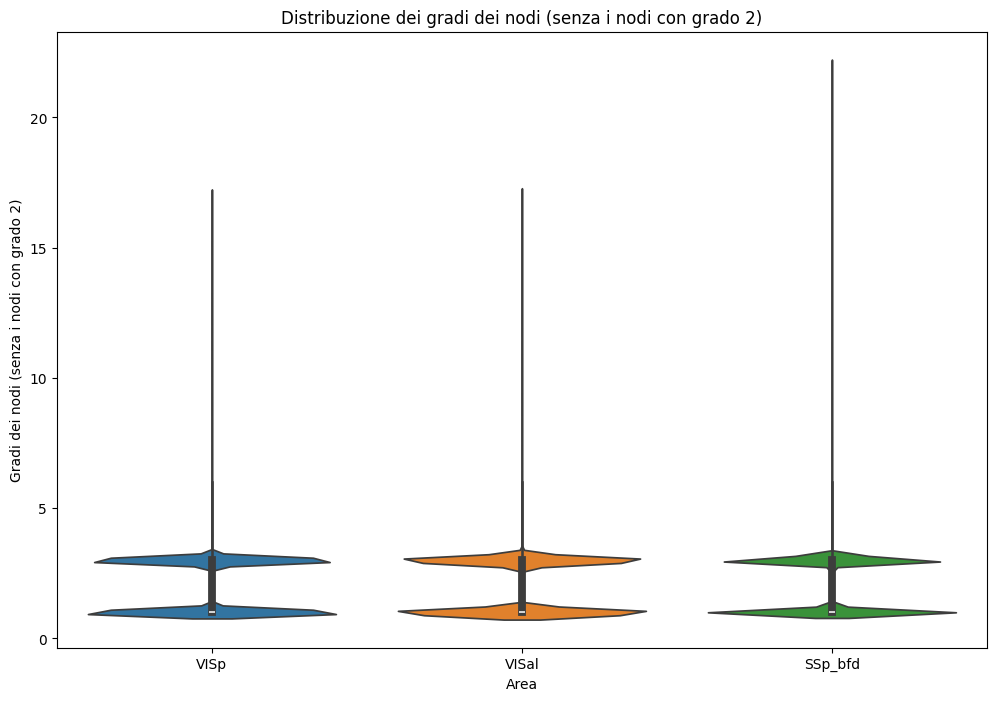

In [16]:
import seaborn as sns
# Funzione per filtrare i nodi con grado diverso da 2
def filter_degrees(degree_list):
    return [degree for degree in degree_list if degree != 2]

# Filtrare i dati
VISp_filtered_degrees = filter_degrees(VISp_degrees)
VISal_filtered_degrees = filter_degrees(VISal_degrees)
SSp_bfd_filtered_degrees = filter_degrees(SSp_bfd_degrees)

# Creare un violino plot per i gradi filtrati
plt.figure(figsize=(12, 8))
sns.violinplot(data=[VISp_filtered_degrees, VISal_filtered_degrees, SSp_bfd_filtered_degrees])
plt.xticks([0, 1, 2], ['VISp', 'VISal', 'SSp_bfd'])
plt.xlabel('Area')
plt.ylabel('Gradi dei nodi (senza i nodi con grado 2)')
plt.title('Distribuzione dei gradi dei nodi (senza i nodi con grado 2)')
plt.show()

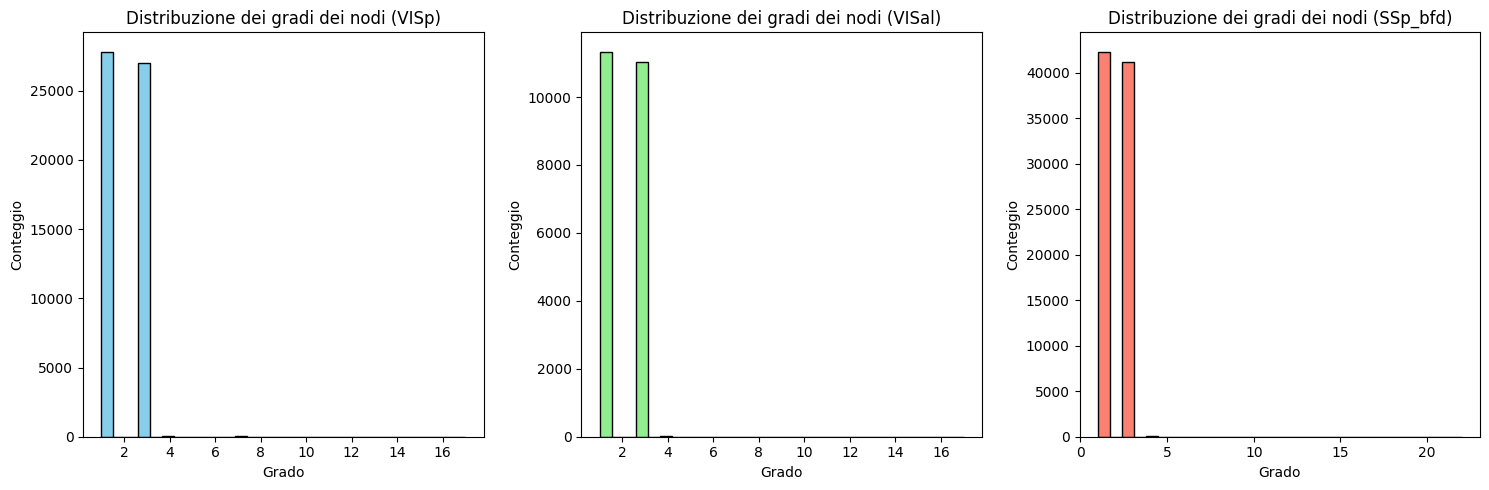

In [17]:
# Creare un istogramma per i gradi filtrati
plt.figure(figsize=(15, 5))

# Istogramma per VISp
plt.subplot(1, 3, 1)
plt.hist(VISp_filtered_degrees, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Grado')
plt.ylabel('Conteggio')
plt.title('Distribuzione dei gradi dei nodi (VISp)')

# Istogramma per VISal
plt.subplot(1, 3, 2)
plt.hist(VISal_filtered_degrees, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Grado')
plt.ylabel('Conteggio')
plt.title('Distribuzione dei gradi dei nodi (VISal)')

# Istogramma per SSp_bfd
plt.subplot(1, 3, 3)
plt.hist(SSp_bfd_filtered_degrees, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Grado')
plt.ylabel('Conteggio')
plt.title('Distribuzione dei gradi dei nodi (SSp_bfd)')

plt.tight_layout()
plt.show()

In [10]:
len(SSp_bfd_degrees)

1182156

In [ ]:
# Funzione per calcolare statistiche di base
def calculate_statistics(degrees):
    mean_val = np.mean(degrees)
    median_val = np.median(degrees)
    std_val = np.std(degrees)
    return mean_val, median_val, std_val

# Funzione per eseguire il test t di Student e il test KS
def perform_stat_tests(degrees1, degrees2):
    t_stat, t_p_val = stats.ttest_ind(degrees1, degrees2)
    ks_stat, ks_p_val = stats.ks_2samp(degrees1, degrees2)
    return t_stat, t_p_val, ks_stat, ks_p_val

# Calcolare statistiche di base
VISp_stats = calculate_statistics(VISp_degrees)
VISal_stats = calculate_statistics(VISal_degrees)
SSp_bfd_stats = calculate_statistics(SSp_bfd_degrees)

# Eseguire test statistici tra le aree
t_stat_VISp_VISal, t_p_val_VISp_VISal, ks_stat_VISp_VISal, ks_p_val_VISp_VISal = perform_stat_tests(VISp_degrees, VISal_degrees)
t_stat_VISp_SSp, t_p_val_VISp_SSp, ks_stat_VISp_SSp, ks_p_val_VISp_SSp = perform_stat_tests(VISp_degrees, SSp_bfd_degrees)
t_stat_VISal_SSp, t_p_val_VISal_SSp, ks_stat_VISal_SSp, ks_p_val_VISal_SSp = perform_stat_tests(VISal_degrees, SSp_bfd_degrees)

# Visualizzare i risultati
print("Statistiche VISp:")
print(f"Media: {VISp_stats[0]:.4f}, Mediana: {VISp_stats[1]:.4f}, Deviazione Standard: {VISp_stats[2]:.4f}")
print("Statistiche VISal:")
print(f"Media: {VISal_stats[0]:.4f}, Mediana: {VISal_stats[1]:.4f}, Deviazione Standard: {VISal_stats[2]:.4f}")
print("Statistiche SSp_bfd:")
print(f"Media: {SSp_bfd_stats[0]:.4f}, Mediana: {SSp_bfd_stats[1]:.4f}, Deviazione Standard: {SSp_bfd_stats[2]:.4f}")

print("\nTest statistici tra VISp e VISal:")
print(f"t-test: t-statistica = {t_stat_VISp_VISal:.4f}, p-value = {t_p_val_VISp_VISal:.4f}")
print(f"KS test: ks-statistica = {ks_stat_VISp_VISal:.4f}, p-value = {ks_p_val_VISp_VISal:.4f}")

print("\nTest statistici tra VISp e SSp_bfd:")
print(f"t-test: t-statistica = {t_stat_VISp_SSp:.4f}, p-value = {t_p_val_VISp_SSp:.4f}")
print(f"KS test: ks-statistica = {ks_stat_VISp_SSp:.4f}, p-value = {ks_p_val_VISp_SSp:.4f}")

print("\nTest statistici tra VISal e SSp_bfd:")
print(f"t-test: t-statistica = {t_stat_VISal_SSp:.4f}, p-value = {t_p_val_VISal_SSp:.4f}")
print(f"KS test: ks-statistica = {ks_stat_VISal_SSp:.4f}, p-value = {ks_p_val_VISal_SSp:.4f}")


Statistiche VISp:
Media: 1.9997, Mediana: 2.0000, Deviazione Standard: 0.2890
Statistiche VISal:
Media: 1.9998, Mediana: 2.0000, Deviazione Standard: 0.2845
Statistiche SSp_bfd:
Media: 1.9998, Mediana: 2.0000, Deviazione Standard: 0.2759

Test statistici tra VISp e VISal:
t-test: t-statistica = -0.0529, p-value = 0.9579
KS test: ks-statistica = 0.0011, p-value = 0.9468

Test statistici tra VISp e SSp_bfd:
t-test: t-statistica = -0.1521, p-value = 0.8791
KS test: ks-statistica = 0.0038, p-value = 0.0000

Test statistici tra VISal e SSp_bfd:
t-test: t-statistica = -0.0542, p-value = 0.9568
KS test: ks-statistica = 0.0027, p-value = 0.0677


### Interpretazione dei Risultati

#### Statistiche Descrittive:

**Statistiche VISp:**
- Media: 1.9997
- Mediana: 2.0000
- Deviazione Standard: 0.2890

**Statistiche VISal:**
- Media: 1.9998
- Mediana: 2.0000
- Deviazione Standard: 0.2845

**Statistiche SSp_bfd:**
- Media: 1.9998
- Mediana: 2.0000
- Deviazione Standard: 0.2759

##### Interpretazione:
- **Media e Mediana:** Le medie e le mediane dei gradi dei nodi sono quasi identiche (circa 2.0000) per tutte e tre le aree cerebrali, indicando che la maggior parte dei nodi ha un grado di 2.
- **Deviazione Standard:** Le deviazioni standard sono molto basse e simili tra loro, suggerendo una bassa variabilità nella distribuzione dei gradi dei nodi all'interno di ciascuna area.

#### Test Statistici:

##### Test tra VISp e VISal:

- **t-test:**
  - t-statistica = -0.0529
  - p-valore = 0.9579

- **KS test:**
  - ks-statistica = 0.0011
  - p-valore = 0.9468

##### Test tra VISp e SSp_bfd:

- **t-test:**
  - t-statistica = -0.1521
  - p-valore = 0.8791

- **KS test:**
  - ks-statistica = 0.0038
  - p-valore = 0.0000

##### Test tra VISal e SSp_bfd:

- **t-test:**
  - t-statistica = -0.0542
  - p-valore = 0.9568

- **KS test:**
  - ks-statistica = 0.0027
  - p-valore = 0.0677

##### Interpretazione:
- **t-test:** Confronta le medie dei gradi dei nodi tra le aree. Tutti i p-valori sono molto alti (> 0.05), indicando che non ci sono differenze statisticamente significative tra le medie dei gradi dei nodi delle aree confrontate.
- **KS test:** Confronta le distribuzioni cumulative dei gradi dei nodi tra le aree.
  - Tra **VISp e VISal**, il p-valore è molto alto (0.9468), indicando che le distribuzioni sono molto simili.
  - Tra **VISp e SSp_bfd**, il p-valore è molto basso (0.0000), suggerendo che c'è una differenza statisticamente significativa tra le distribuzioni delle due aree.
  - Tra **VISal e SSp_bfd**, il p-valore (0.0677) è leggermente sopra il livello di significatività comune (0.05), suggerendo una possibile differenza, ma non abbastanza forte da essere considerata significativa al 95% di confidenza.

### Conclusioni:

1. **Distribuzione Simile:** Le statistiche descrittive mostrano che le distribuzioni dei gradi dei nodi sono molto simili tra le tre aree cerebrali.
2. **Differenze Minime:** I t-test indicano che non ci sono differenze significative nelle medie dei gradi dei nodi tra le aree.
3. **Differenza tra VISp e SSp_bfd:** Il KS test rileva una differenza significativa tra le distribuzioni dei gradi dei nodi di VISp e SSp_bfd, suggerendo una variabilità strutturale tra queste due aree.
4. **Distribuzione dei Gradi dei Nodi:** La distribuzione dei gradi dei nodi è generalmente uniforme e bassa variabilità all'interno di ciascuna area, con la maggior parte dei nodi aventi un grado di 2.

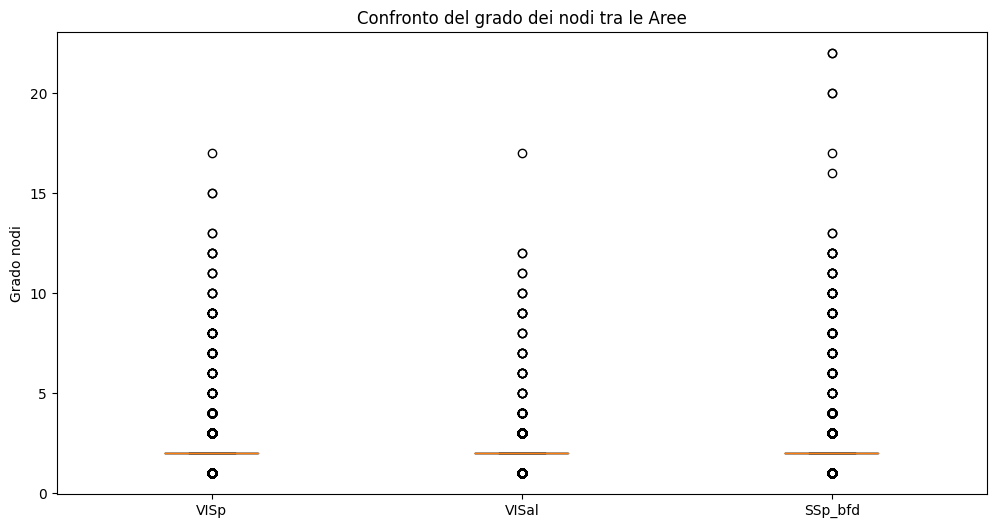

In [ ]:
# Visualizzazione dei risultati
plt.figure(figsize=(12, 6))
plt.boxplot([VISp_degrees, VISal_degrees, SSp_bfd_degrees], labels=['VISp', 'VISal', 'SSp_bfd'])
plt.ylabel('Grado nodi')
plt.title('Confronto del grado dei nodi tra le Aree')
plt.show()